In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('data_raw.csv')
pivot_data = data.pivot(index='date', columns='commodity', values='close') 

## Feature transforms

### Normality

First, we'll try to coerce our data into a normal distribution. To begin, we'll plot the current distributions of each feature and test whether they're normal.

H<sub>0</sub>: data is from a normal distribution <br>
H<sub>a</sub>: data is NOT from a normal distribution

Normal test results:
Cocoa: p = 0.0
Coffee: p = 3.723478999045813e-84
Cotton: p = 0.0
Random Length Lumber: p = 0.0
Orange Juice: p = 7.158118776998875e-62


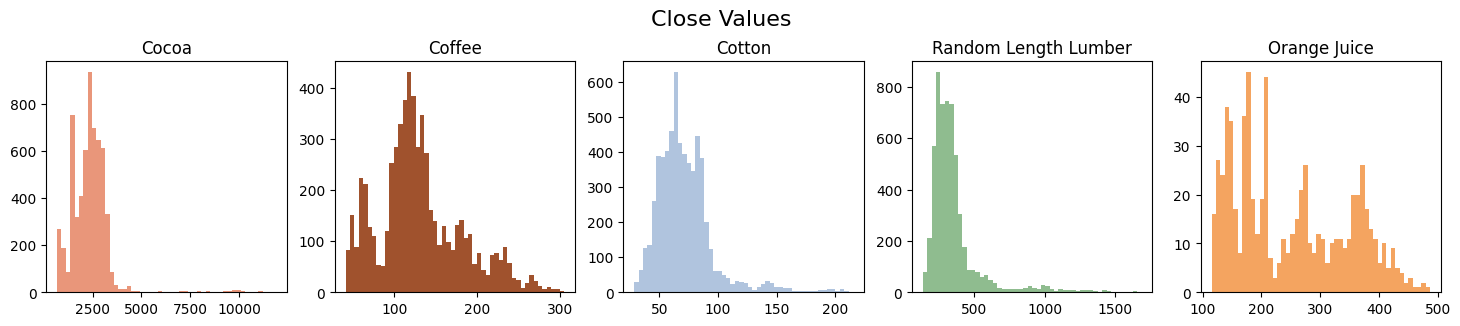

In [10]:
from scipy.stats import normaltest

# create figure
fig, axes = plt.subplots(1, 5, figsize=(18, 3)) 

commodities = ['Cocoa', 'Coffee', 'Cotton', 'Random Length Lumber', 'Orange Juice', 'Sugar']
colors = ['darksalmon', 'sienna', 'lightsteelblue', 'darkseagreen', 'sandybrown', 'plum']

print('Normal test results:')

for col, color, ax in zip(commodities, colors, axes.flat):
    # plot histogram
    ax.set_title(col)  
    ax.hist(pivot_data[col], bins = 50, color=color)

    # normal test
    _, p = normaltest(pivot_data[col].dropna())
    print(f'{col}: p = {p}')

fig.text(0.5, 1.0, 'Close Values', ha='center', fontsize=16.0) # figure title
plt.show()

None of them look normal and the test confirms it. Now let's see how the features respond to a log transformation.

Normal test results:
Cocoa: p = 5.952335557683281e-74
Coffee: p = 2.3493144922056383e-30
Cotton: p = 6.6656826481708405e-71
Random Length Lumber: p = 1.0033051832338973e-295
Orange Juice: p = 2.206348361906832e-277


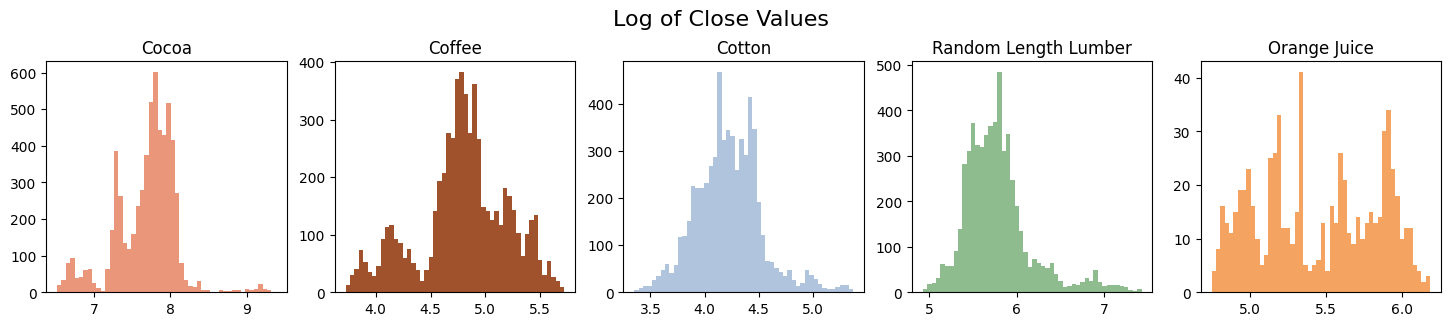

In [11]:
# plot histograms
fig, axes = plt.subplots(1, 5, figsize=(18, 3)) 

print('Normal test results:')

for col, color, ax in zip(commodities, colors, axes.flat):

    # transform data
    data_log = np.log(pivot_data[col].dropna())

    ax.set_title(col)  
    ax.hist(data_log, bins = 50, color=color)

    _, p = normaltest(data_log)
    print(f'{col}: p = {p}')

fig.text(0.5, 1.0, 'Log of Close Values', ha='center', fontsize=16.0) # figure title
plt.show()

Well... I guess it sort of helped, but not really. Let's try a Box-Cox transformation. 

Normal test results:
Cocoa: p = 2.1736066277699972e-79
Coffee: p = 1.1163236521971831e-05
Cotton: p = 4.713352052857154e-12
Random Length Lumber: p = 4.468241283163777e-09
Orange Juice: p = 8.664492741820261e-277


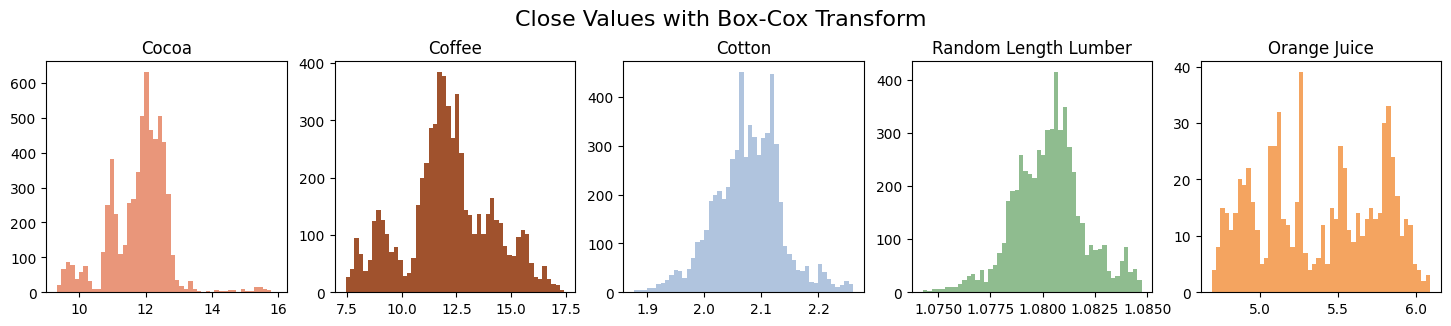

In [12]:
from scipy.stats import boxcox

# plot histograms
fig, axes = plt.subplots(1, 5, figsize=(18, 3)) 

print('Normal test results:')

for col, color, ax in zip(commodities, colors, axes.flat):

    # transform data
    data_bc = boxcox(pivot_data[col].dropna())[0]

    ax.set_title(col)  
    ax.hist(data_bc, bins = 50, color=color)

    _, p = normaltest(data_bc)
    print(f'{col}: p = {p}')

fig.text(0.5, 1.0, 'Close Values with Box-Cox Transform', ha='center', fontsize=16.0) # figure title
plt.show()

This is almost identical to the log transform, which is unsurprising as boxcox is related. Let's try something else, like a quantile transform. 

Normal test results:
Cocoa: p = [0.91079139]
Coffee: p = [0.88187767]
Cotton: p = [0.52057937]
Random Length Lumber: p = [0.65538809]
Orange Juice: p = [2.19102643e-05]


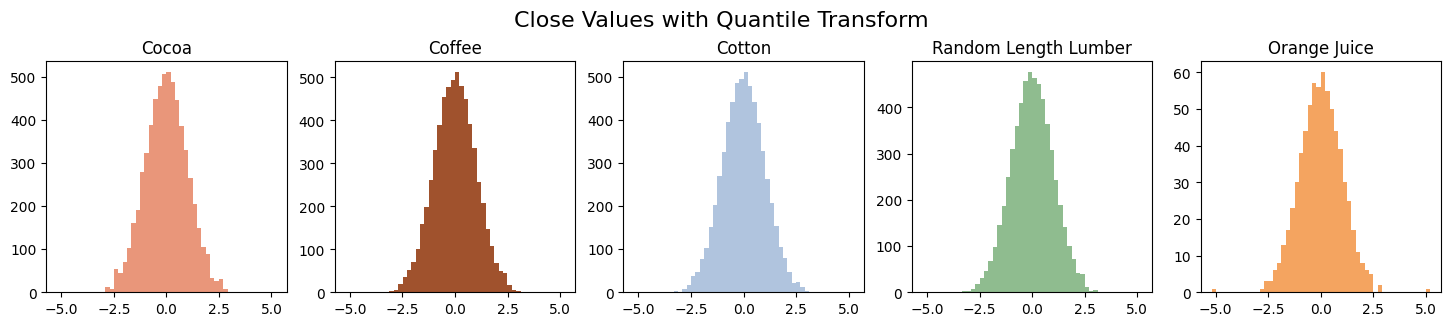

In [13]:
from sklearn.preprocessing import quantile_transform

# plot histograms
fig, axes = plt.subplots(1, 5, figsize=(18, 3)) 

print('Normal test results:')

for col, color, ax in zip(commodities, colors, axes.flat):

    data = np.array(pivot_data[col].dropna()).reshape(-1, 1) # convert feature to 1d array

    # transform data
    data_qt = quantile_transform(data, n_quantiles=100, output_distribution='normal')

    ax.set_title(col)  
    ax.hist(data_qt, bins = 50, color=color)

    _, p = normaltest(data_qt)
    print(f'{col}: p = {p}')

fig.text(0.5, 1.0, 'Close Values with Quantile Transform', ha='center', fontsize=16.0) # figure title
plt.show()

That was incredibly effective! Orange juice still has a low p value, but we can see that there are a couple of outliers which aren't present in the other features, so that might be screwing up the numbers. Regardless, it looks pretty normal-like to me. Let's see what the features look like if we plot the transformed data against time.

In [14]:
# save transformed data

data_transform = pd.DataFrame()
data_transform['Date'] = pivot_data.index

for col in commodities:
    data = np.array(pivot_data[col]).reshape(-1, 1) # convert feature to 1d array
    data_qt = quantile_transform(data, n_quantiles=100, output_distribution='normal')

    data_transform[col] = data_qt

data_transform

,Date,Cocoa,Coffee,Cotton,Random Length Lumber,Orange Juice,Sugar
0,2000-01-03,-1.868732,-0.206547,-0.971538,NaN,NaN,NaN
1,2000-01-04,-1.847124,-0.215177,-0.994814,NaN,NaN,NaN
2,2000-01-05,-1.865070,-0.134598,-0.940643,NaN,NaN,NaN
3,2000-01-06,-1.829754,-0.194491,-0.907798,NaN,NaN,NaN
4,2000-01-07,-1.790181,-0.289873,-0.789612,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6157,2024-06-17,2.522188,1.556593,0.113301,NaN,1.982567,0.705083
6158,2024-06-18,2.569098,1.538444,0.171689,NaN,1.684527,0.695360
6159,2024-06-20,2.512634,1.612656,0.163689,NaN,1.825054,0.690625
6160,2024-06-21,2.428710,1.544676,0.016249,NaN,1.943138,0.703441


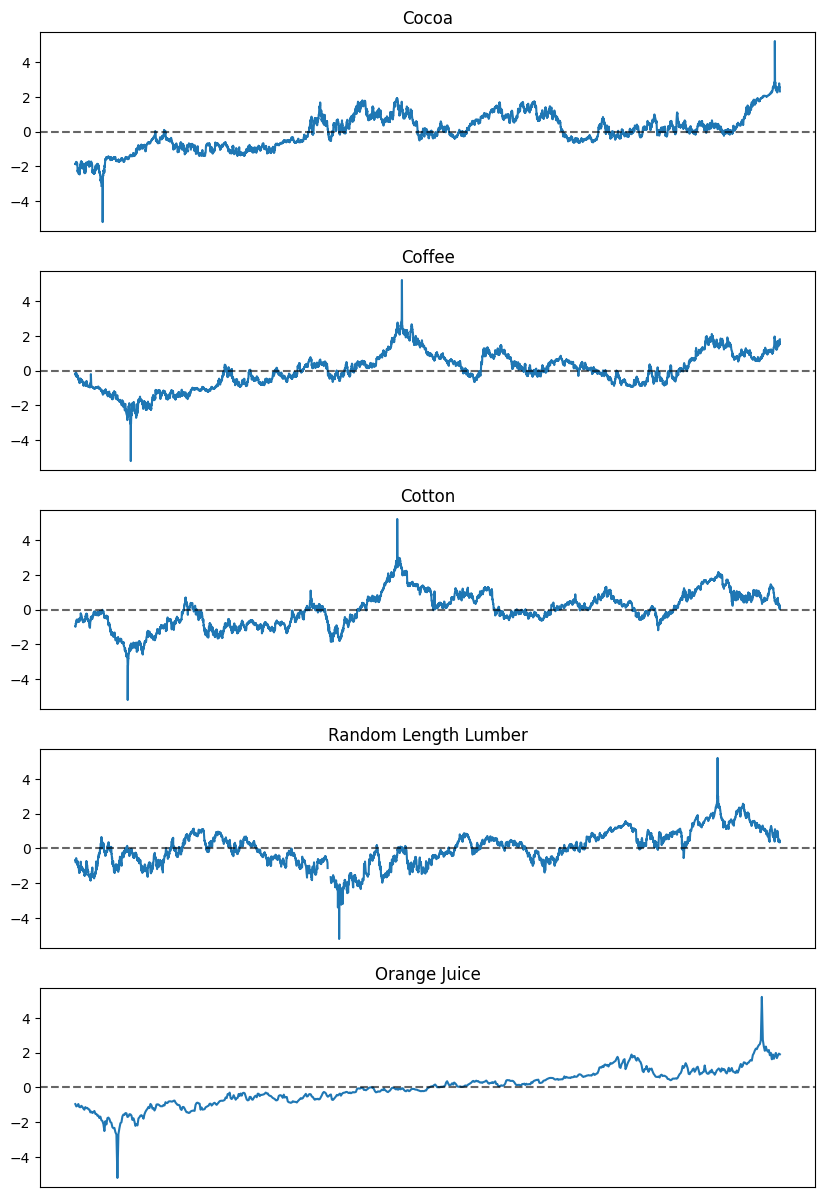

In [15]:
# plot transformed features against date

fig, axes = plt.subplots(5, 1, figsize=(10, 15))

for col, ax in zip(commodities, axes.flat):
    ax.plot(data_transform[col])
    ax.axhline(0, color='black', linestyle='--', alpha=0.6)
    ax.get_xaxis().set_visible(False)
    ax.set_title(col)

plt.show()

Now let's inspect linearity and stationarity and also look at the decompositions to see if the transformed features are more regular than the untransformed data.

### Stationarity

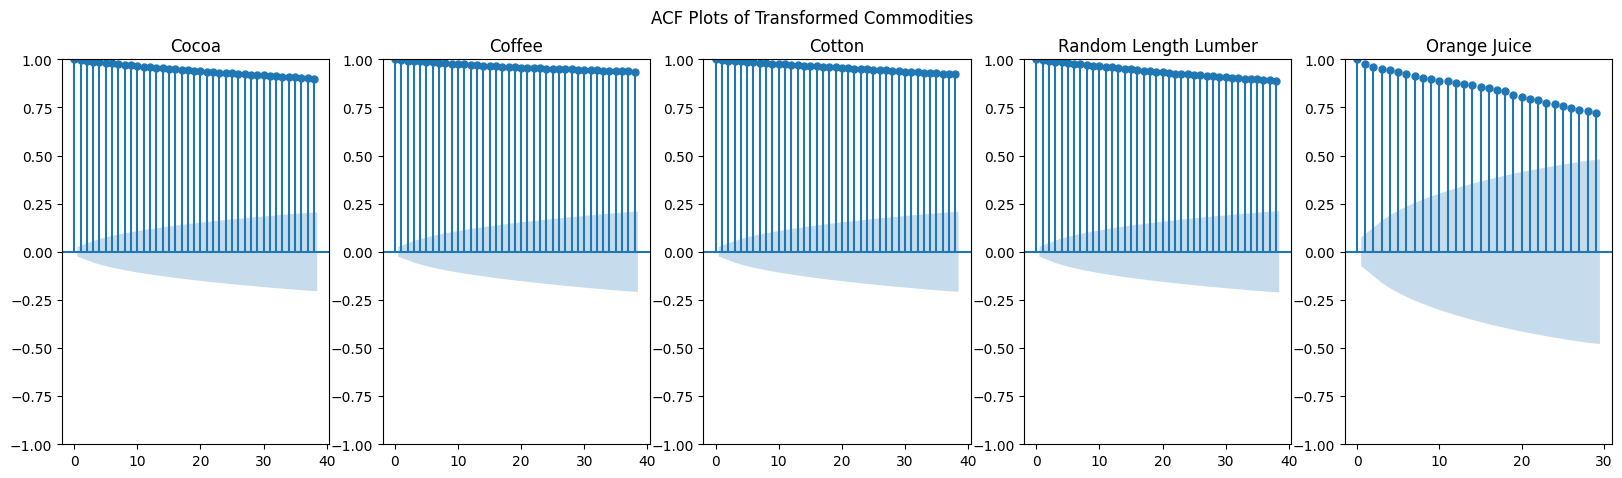

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('ACF Plots of Transformed Commodities')

for col, ax in zip(commodities, axes.flat):
    plot_acf(data_transform[col].dropna(), ax=ax)
    ax.set_title(col)
plt.show()

These are not stationary. 

### Linearity

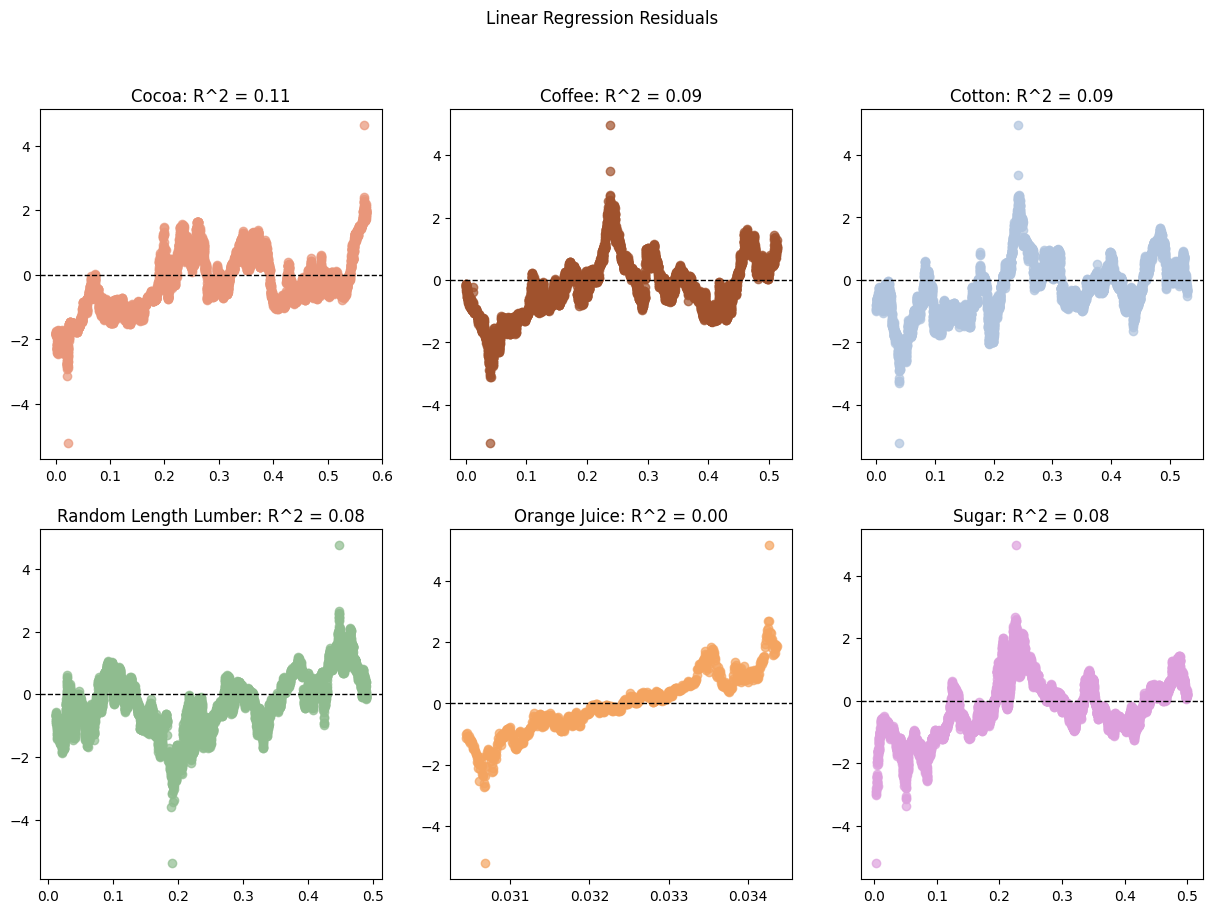

In [17]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# add an intercept column
data_transform_lr = sm.add_constant(data_transform)

# use a series of integers for X (instead of dates)
X = np.arange(1, len(data_transform_lr)+1)

colors = ['darksalmon', 'sienna', 'lightsteelblue', 'darkseagreen', 'sandybrown', 'plum']

# for each commodity, fit linear regression and plot residuals

# create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 
plt.suptitle('Linear Regression Residuals')

for commodity, ax, color in zip(commodities, axes.flat, colors):

    # fit linear regression
    model = OLS(endog = data_transform_lr[commodity], exog = X, missing='drop').fit()

    # get R^2
    r_squared = model.rsquared
    r_squared = f'{r_squared:.2f}' # format for axis titles

    # get residuals
    fitted = model.fittedvalues  
    residuals = model.resid

    # plot residuals
    ax.scatter(fitted, residuals, alpha=0.7, color=color)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # horizontal line at y=0
    ax.set_title(f'{commodity}: R^2 = {r_squared}')
    ax.set_xlabel('')
    ax.set_ylabel('')

No, definitely not linear.

### Decomposition

In [18]:
# Fourier transform

from scipy.fft import fft

print('Estimated period:')

for col in commodities:
    N = len(data_transform[col].dropna())
    fft_vals = np.abs(fft(data_transform[col].dropna()))
    frequencies = np.fft.fftfreq(N)

    dominant_frequency = np.argmax(fft_vals[1:]) + 1
    period = N / dominant_frequency
    print(f"{col}: {int(period)}")

Estimated period:
Cocoa: 6137
Coffee: 3067
Cotton: 6136
Random Length Lumber: 5723
Orange Juice: 704
Sugar: 3048


C:\Users\Melanie\AppData\Local\Temp\ipykernel_1856\2614447917.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1 / frequencies, power, color = color)


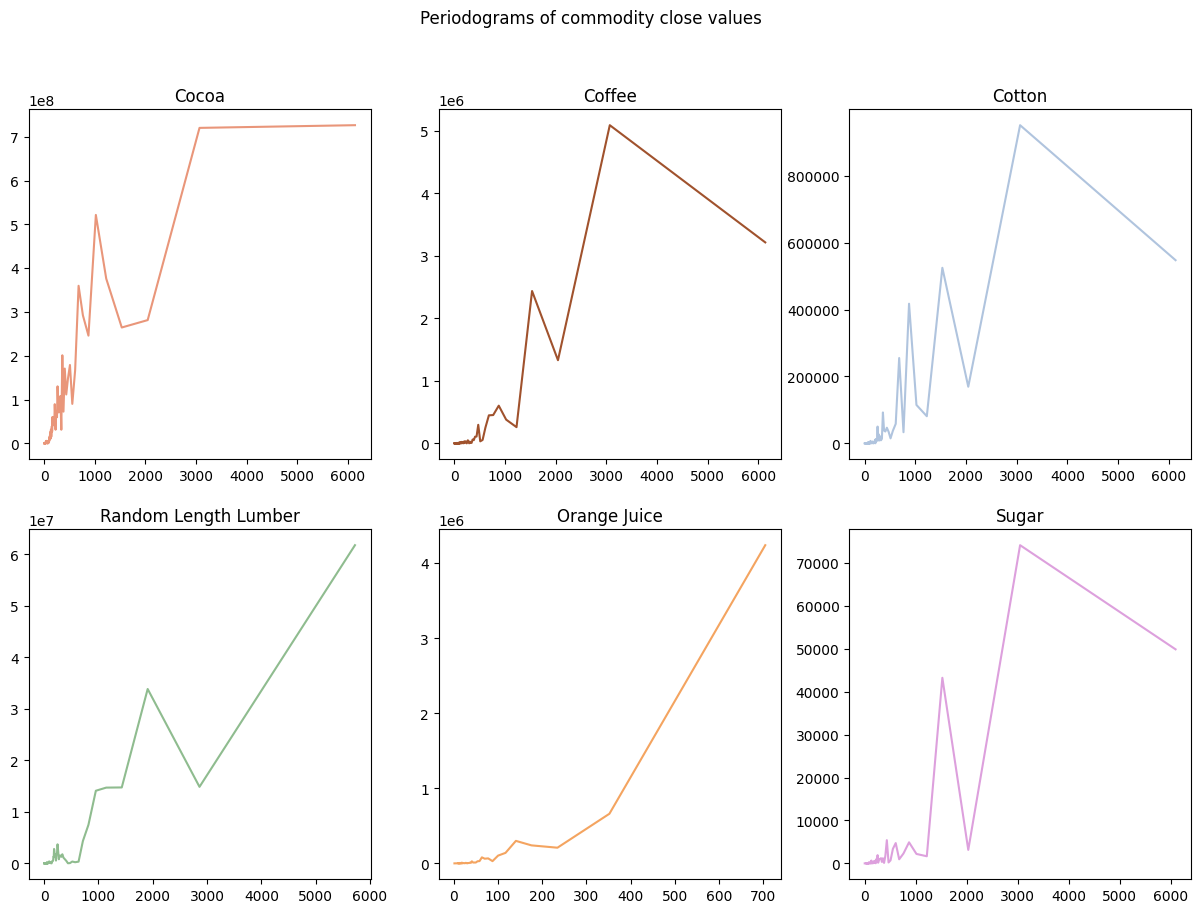

In [19]:
from scipy.signal import periodogram

fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 
plt.suptitle('Periodograms of commodity close values')

for commodity, ax, color in zip(commodities, axes.flat, colors):
    frequencies, power = periodogram(pivot_data[commodity].dropna())
    ax.plot(1 / frequencies, power, color = color)
    ax.set_title(commodity)
plt.show()

The periododicity shows the same patterns as in the untransformed data. It seems like the transformation hasn't made the series more regular.

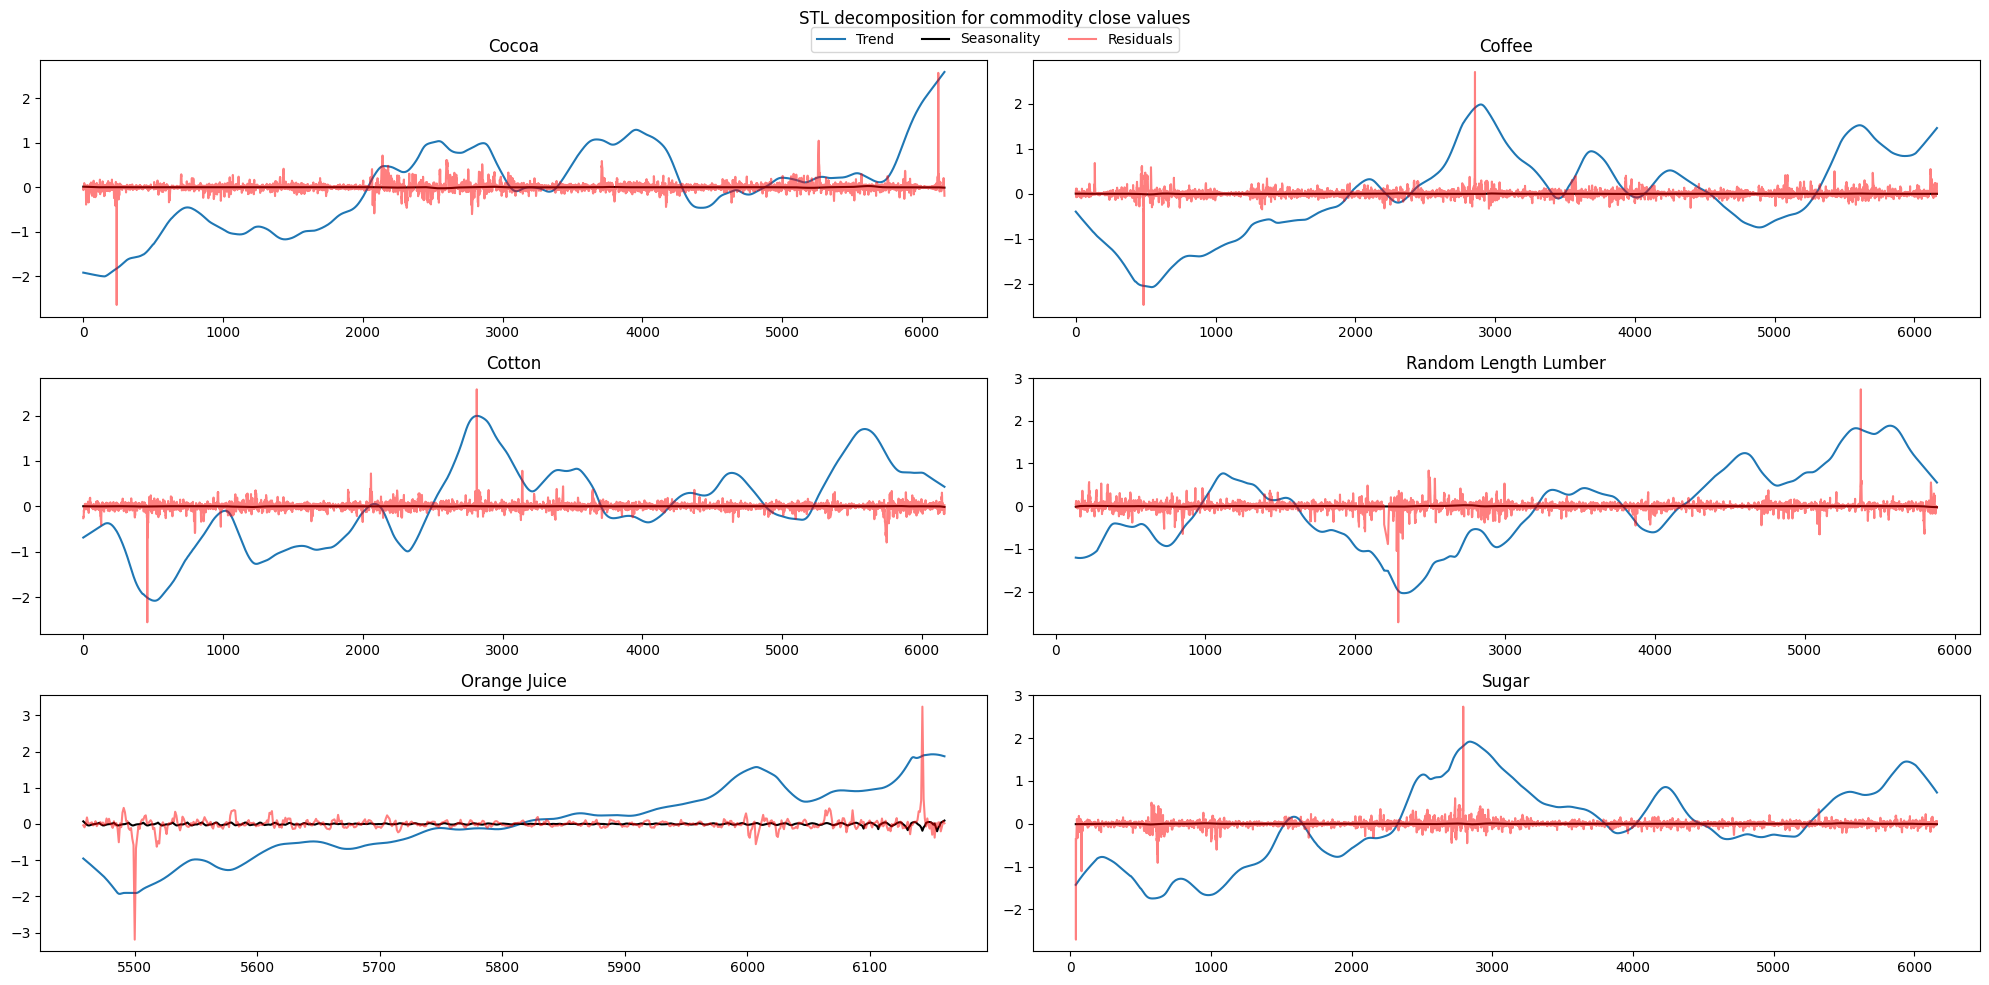

In [20]:
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess

# create plt figure
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
fig.suptitle('STL decomposition for commodity close values')

# for each commodity and axis in the figure
for col, ax in zip(commodities, axes.flat):
    
    # get the series for the current commodity
    data = data_transform[col].dropna()

    # STL decomposition
    stl = STL(data, period=12, seasonal=25, robust=True)
    stl_fit = stl.fit()
    stl_trend = stl_fit.trend
    stl_season = stl_fit.seasonal
    stl_resid = stl_fit.resid

    # smooth the trend
    frac = 0.05  # smoothing factor (larger = smoother)
    stl_trend_smooth = lowess(stl_trend, np.arange(len(stl_trend)), frac=frac)[:, 1]
    stl_trend_smooth = pd.Series(stl_trend_smooth) #convert from np to series for plotting
    stl_trend_smooth.index = data.index #align indices for plotting

    # smooth the seasonality
    frac = 0.01
    stl_season_smooth = lowess(stl_season, np.arange(len(stl_season)), frac=frac)[:, 1]
    stl_season_smooth = pd.Series(stl_season_smooth) #convert from np to series for plotting
    stl_season_smooth.index = data.index #align indices for plotting
    stl_resid.index = data.index #align indices for plotting
    
    # plot components
    ax.plot(stl_trend_smooth, label='Trend')
    ax.plot(stl_season_smooth, color='black', label='Seasonality')
    ax.plot(stl_resid, alpha=0.5, color='red', label='Residuals')
    ax.set_title(col)
    ax.set_xlabel('')
            
# create legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=3)

plt.tight_layout()
plt.show()

The trends mostly look similar to the untransformed data, only centered on the x axis. There are no apparent meaningful changes in the residuals or seasonality either, keeping the different scale in mind. 

So it seems that coercing the data into a normal distribution doesn't make it any more regular, only allows for the normal assumption to be satisfied for the prediction methods that require it. 

## Feature extraction

We'll create two feature subsets: one using itertools and another using ROCKET. 

At this point, we'll create separate dataframes for each commodity, since each will have features unique to itself. Some non-linear relationships exist between different commodities, so we should keep all of them as features. In other words, we will build 6 different models, each of which forecasts a different commodity y. In these models, all commodities except y are included as features. 

### Featuretools

In [13]:
import featuretools as ft
from featuretools.primitives import Day, DayOfYear, Month, Quarter, Season, Week, Year, Weekday, IsFederalHoliday, IsMonthEnd, IsMonthStart, IsQuarterEnd, IsQuarterStart, IsWeekend, IsYearEnd, IsYearStart

# create new data frames for each commodity
def new_df(commodity):

    new_df = data_transform[[commodity, 'Date']]
    new_df = new_df.dropna(axis=0, ignore_index=True)
    new_df['id'] = new_df.index

    return new_df

cocoa_ft = new_df('Cocoa')
coffee_ft = new_df('Coffee')
cotton_ft = new_df('Cotton')
lumber_ft = new_df('Random Length Lumber')
orangejuice_ft = new_df('Orange Juice')
sugar_ft = new_df('Sugar')

# create entity set with all new dataframes
es = ft.EntitySet()
for com, df in zip(commodities, [cocoa_ft, coffee_ft, cotton_ft, lumber_ft, orangejuice_ft, sugar_ft]):
    es.add_dataframe(
        dataframe_name = com,
        index = 'id',
        dataframe = df,
        time_index = 'Date'
    )

# get names of all valid features that could be calculated
# should be the same for every commodity, so only call once
ap, tp = ft.get_valid_primitives(
            entityset=es,
            target_dataframe_name = 'Cocoa',
            max_depth=1
        )

# for each commodity, calculate all new features and add to existing df
def get_features(df, commodity, ap=ap, tp=tp):
    fm, features = ft.dfs(
        entityset = es,
        target_dataframe_name = commodity,
        max_depth=1,
        agg_primitives = ap,
        trans_primitives = tp
    )
    join_cols_fm = [col for col in fm.columns if col not in df.columns] # add extracted features
    #join_cols_commodities = [col for col in data_transform if col not in df.columns] # add other commodities
    new_df = pd.concat([df, fm[join_cols_fm]], axis=1)
    #new_df = pd.concat([new_df, data_transform[join_cols_commodities]], axis=1)
    return new_df

cocoa_ft = get_features(cocoa_ft, 'Cocoa')
coffee_ft = get_features(coffee_ft, 'Coffee')
cotton_ft = get_features(cotton_ft, 'Cotton')
lumber_ft = get_features(lumber_ft, 'Random Length Lumber')
orangejuice_ft = get_features(orangejuice_ft, 'Orange Juice')
sugar_ft = get_features(sugar_ft, 'Sugar')

c:\Users\Melanie\anaconda3\envs\3.12\Lib\site-packages\featuretools\primitives\standard\transform\time_series\numeric_lag.py:48: FutureWarning: NumericLag is deprecated and will be removed in a future version. Please use the 'Lag' primitive instead.
  warnings.warn(
c:\Users\Melanie\anaconda3\envs\3.12\Lib\site-packages\featuretools\primitives\standard\transform\absolute_diff.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method=self.method, limit=self.limit).diff().abs()
c:\Users\Melanie\anaconda3\envs\3.12\Lib\site-packages\featuretools\primitives\standard\transform\numeric\same_as_previous.py:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method=self.fill_method, limit=self.limit)
c:\Users\Melanie\anaconda3\envs\3.12\Lib\site-packages\featuretools\primitives\standard\

In [14]:
print(cocoa_ft.shape)
cocoa_ft.columns

(6137, 100)


Index(['Cocoa', 'Date', 'id', 'ABSOLUTE(Cocoa)', 'ABSOLUTE_DIFF(Cocoa)',
       'Cocoa + 0', 'COSINE(Cocoa)', 'CUM_MAX(Cocoa)', 'CUM_MEAN(Cocoa)',
       'CUM_MIN(Cocoa)', 'CUM_SUM(Cocoa)', 'DATE_TO_HOLIDAY(Date)',
       'DATE_TO_TIME_ZONE(Date)', 'DAY(Date)', 'DAY_OF_YEAR(Date)',
       'DAYS_IN_MONTH(Date)', 'DIFF(Cocoa)', 'DISTANCE_TO_HOLIDAY(Date)',
       '1 / Cocoa', 'Cocoa / 1', 'Cocoa = Date', 'Cocoa = id', 'Date = id',
       'Cocoa = None', 'Date = None', 'id = None', 'EXPANDING_COUNT(Date)',
       'EXPANDING_MAX(Date, Cocoa)', 'EXPANDING_MEAN(Date, Cocoa)',
       'EXPANDING_MIN(Date, Cocoa)', 'EXPANDING_STD(Date, Cocoa)',
       'EXPANDING_TREND(Date, Cocoa)',
       'EXPONENTIAL_WEIGHTED_AVERAGE(Cocoa, com=0.5)',
       'EXPONENTIAL_WEIGHTED_STD(Cocoa, com=0.5)',
       'EXPONENTIAL_WEIGHTED_VARIANCE(Cocoa, com=0.5)', 'Cocoa >= 0',
       'Cocoa > 0', 'HOUR(Date)', 'IS_FEDERAL_HOLIDAY(Date)',
       'IS_FIRST_WEEK_OF_MONTH(Date)', 'IS_LEAP_YEAR(Date)',
       'IS_LUNCH_T

### ROCKET

ROCKET is ideal for automated, large-scale applications such as financial forecasting. While it's not interpretable like shapelets is, interpretability isn't a key consideration for this application. Accurate predictions and strategic trading decisions are the priority, and ROCKET is more accurate than shapelets. 

In [30]:
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket

# perform quantile transform such that sktime compatible indexing is preserved
rocket_df = pd.read_csv('data_raw.csv')
rocket_df = rocket_df.pivot(index='date', columns='commodity', values='close')

for col in commodities:
    data = np.array(pivot_data[col]).reshape(-1, 1) # convert feature to 1d array
    data_qt = quantile_transform(data, n_quantiles=100, output_distribution='normal')

    rocket_df[col] = data_qt

# train rocket on a train sample of the data
rocket_df = rocket_df.sample(frac = 0.7, axis=0, ignore_index=True)

# format data
rocket_df = rocket_df.fillna(0)
df_nested = from_2d_array_to_nested(rocket_df.T)

# train rocket
rocket = Rocket()
rocket_res = rocket.fit_transform(df_nested)
rocket_res

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.426945,8.837323,0.548054,8.158916,0.441456,8.701836,0.484582,12.601409,0.472525,20.077454,...,0.407141,9.736846,0.413579,9.075334,0.538858,11.750757,0.623000,8.091332,0.579281,11.238557
1,0.429501,7.851599,0.552876,8.351543,0.436123,9.495170,0.490842,15.935477,0.461628,16.804052,...,0.413169,10.134175,0.414057,12.549989,0.533709,17.399406,0.614885,7.301855,0.545455,12.089734
2,0.428107,8.281970,0.549432,7.847200,0.451426,9.888042,0.495015,12.824080,0.469974,18.707182,...,0.409228,9.103891,0.415969,9.661394,0.526845,10.382247,0.617204,7.444612,0.570825,9.023138
3,0.243206,20.793606,0.695832,15.962504,0.251565,16.823658,0.291213,38.227970,0.321354,36.032494,...,0.204962,27.421713,0.247908,18.922159,0.734003,30.066717,0.752840,14.776142,0.803383,35.833721
4,0.435075,9.835870,0.549087,9.511086,0.441456,10.801553,0.483422,17.575180,0.472061,18.818254,...,0.402040,9.831948,0.414774,9.392036,0.533709,11.535025,0.617667,7.640324,0.600423,10.705655
5,0.433449,8.876219,0.558732,8.312169,0.434269,8.552296,0.485045,10.670991,0.458845,15.823136,...,0.404127,10.775512,0.414057,9.810966,0.530522,11.305675,0.625551,7.307749,0.579281,8.508742
